# Time Domain Spectral Simulations

This notebook is meant to be run on NERSC. It takes the output of the *transients* branch of `desisim` and plots simulated fluxes. In this particular case, we read simulated SNe Ia on top of BGS host galaxies.

Note that these simulations were run with 300 s exposures using unrealistically dark sky backgrounds.

In [1]:
from astropy.io import fits
from astropy.table import Table, vstack

from desispec.io.spectra import read_spectra

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.signal import medfilt

from glob import glob

## Simulated Files

For now each group of spectra contains three files:
1. A "truth" giving the spectrum parameters, host and spectrum flux templates, etc.
1. A "spectra" file with realizations of spectra in the *b*, *r*, and *z* filters.
1. A "coadd" file containing cleaned-up spectra added across the three filters. This is probably the version appropriate for running something like AstroDASH.

For example, here are the files corresponding to the first group of 100 SNe Ia from the transients branch of `desisim`:

In [2]:
glob('/global/project/projectdirs/desi/users/sybenzvi/bgs/sne_ia/01/bgs_sneia_001*fits')

['/global/project/projectdirs/desi/users/sybenzvi/bgs/sne_ia/01/bgs_sneia_001_coadd.fits',
 '/global/project/projectdirs/desi/users/sybenzvi/bgs/sne_ia/01/bgs_sneia_001_truth.fits',
 '/global/project/projectdirs/desi/users/sybenzvi/bgs/sne_ia/01/bgs_sneia_001_spectra.fits']

In [3]:
truth_file = '/global/project/projectdirs/desi/users/sybenzvi/bgs/sne_ia/01/bgs_sneia_001_truth.fits'
spec_file = '/global/project/projectdirs/desi/users/sybenzvi/bgs/sne_ia/01/bgs_sneia_001_spectra.fits'
coadd_file = '/global/project/projectdirs/desi/users/sybenzvi/bgs/sne_ia/01/bgs_sneia_001_coadd.fits'

### Contents of the Truth File

In [4]:
f = fits.open(truth_file)
wave = f['WAVE'].data
truth = f['TRUTH'].data
objtruth = f['OBJTRUTH'].data

sn_mag = []
sn_truez = []
sn_flux_r = []
sn_target_ids = []
sn_flux_ratios = []
sn_spectrum_idx = []

# Grab simulated target IDs.
sn_target_ids.extend(truth['TARGETID'].tolist())
sn_spectrum_idx.extend(list(range(len(truth))))

# Grab simulated magnitudes and fluxes.
sn_mag.extend(truth['MAG'].tolist())
sn_flux_r.extend(truth['FLUX_R'].tolist())
sn_truez.extend(truth['TRUEZ'].tolist())
sn_flux_ratios.extend(truth['SNE_FLUXRATIO'].tolist())

Make some basic plots of the redshift and magnitude distribution of the simulations.

[Text(0,0.5,'$r$ mag'), Text(0.5,0,'redshift $z$')]

/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


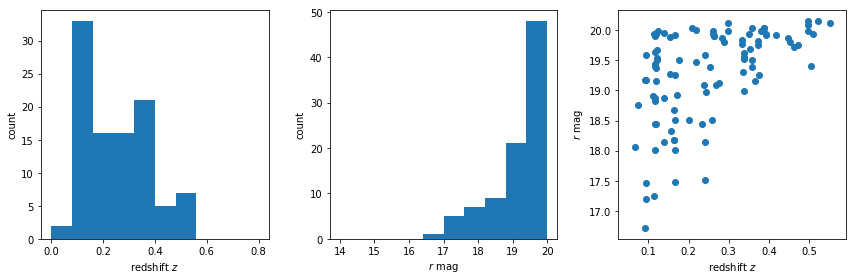

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(12,4), tight_layout=True)
ax = axes[0]
ax.hist(sn_truez, bins=np.linspace(0, 0.8, 11))
ax.set(xlabel='redshift $z$', ylabel='count')

ax = axes[1]
ax.hist(sn_mag, bins=np.linspace(14., 20., 11))
ax.set(xlabel='$r$ mag', ylabel='count')

ax = axes[2]
ax.scatter(sn_truez, sn_mag)
ax.set(xlabel='redshift $z$', ylabel='$r$ mag')

## Read the Spectrum File

Access the spectrum file using existing code from `desispec.io`.

In [6]:
# Ouput will be of type desispec.spectra
spectra = read_spectra(spec_file)
help(spectra)

Help on Spectra in module desispec.spectra object:

class Spectra(builtins.object)
 |  Represents a grouping of spectra.
 |  
 |  This class contains an "extended" fibermap that has information about
 |  the night and exposure of each spectrum.  For each band, this class has 
 |  the wavelength grid, flux, ivar, mask, and resolution arrays.
 |  
 |  Parameters
 |  ----------
 |  bands : :class:`list`
 |      List of strings used to identify the bands.
 |  wave : :class:`dict`
 |      Dictionary of arrays specifying the wavelength grid.
 |  flux : :class:`dict`
 |      Dictionary of arrays specifying the flux for each spectrum.
 |  ivar : :class:`dict`
 |      Dictionary of arrays specifying the inverse variance.
 |  mask : :class:`dict`, optional
 |      Dictionary of arrays specifying the bitmask.
 |  resolution_data : :class:`dict`, optional
 |      Dictionary of arrays specifying the block diagonal resolution matrix.
 |      The object for each band must be in one of the formats sup

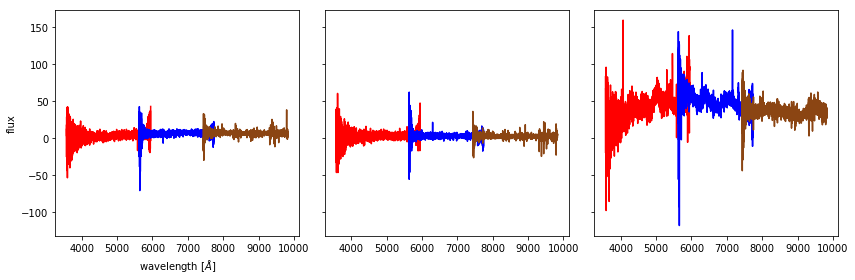

In [7]:
# Plot three of the spectra, chosen randomly.

wave = spectra.wave
flux = spectra.flux

fig, axes = plt.subplots(1, 3, figsize=(12,4), sharex=True, sharey=True)

idx = np.random.choice(len(flux), 3, replace=False)
# spectra.flux['b']    
for i in idx:
    ax = axes[i]
    for _filt, _col in zip('brz', ['r', 'b', 'saddlebrown']):
        wl = wave[_filt]
        fl = flux[_filt][i]
        ax.plot(wl, fl, color=_col)

axes[0].set(xlabel=r'wavelength [$\AA$]',
            ylabel=r'flux')

fig.tight_layout()

## Read the "Co-added" Cleaned Spectrum

In [8]:
hdus = fits.open(coadd_file)
for hdu in hdus:
    print(hdu.header['EXTNAME'])

WAVE
FLUX
FIBERMAP


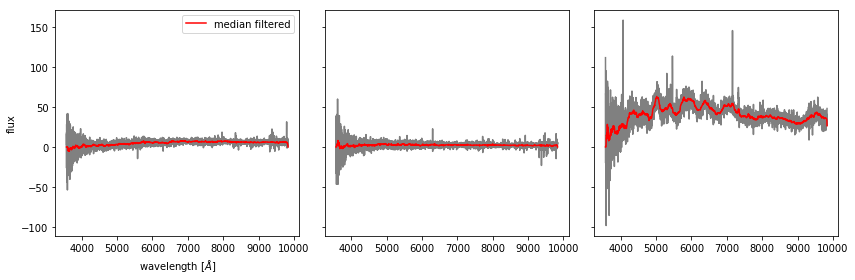

In [9]:
wave = hdus['WAVE'].data
flux = hdus['FLUX'].data

fig, axes = plt.subplots(1, 3, figsize=(12,4), sharex=True, sharey=True)

for i in idx:
    ax = axes[i]
    ax.plot(wave, flux[i], color='gray')
    
    flux_mf = medfilt(flux[i], kernel_size=51)
    ax.plot(wave, flux_mf, 'r', label='median filtered')

axes[0].set(xlabel=r'wavelength [$\AA$]',
            ylabel=r'flux')
axes[0].legend(fontsize=10)

fig.tight_layout()